# Portfolio
- Goals
    - Utilise different machine learnign models to train the financial data and build portfolio of stocks
- Data
    - The data include five table from TEJ database, which include ~ \
`Data: ~, download manually` \
`Data in TEJ_Portfolio: ~, with API to download`

## 1. Setting and Data

### 1.1 Lib pip/ Colab Operation
```do not run if not in colab```

In [ ]:
!pip install optuna
"""
# mount
from google.colab import drive
drive.mount('/content/drive')
# path
os.chdir('/content/drive/MyDrive/portfolio/data')
import sys
sys.path.append(sys.path[0] + f"/drive/MyDrive/portfolio") # current path + ~
"""

### Lib import

In [1]:
%load_ext autoreload
%autoreload 2'
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# other
import os, copy, math
import gc, pickle, warnings
warnings.filterwarnings('ignore')

# -----------------------------------------------
from train import summary
from models.ensmeble import ensemble

### Load Data
- Three Types of Data for Different Industries
    - Automobile (mainly this)
    - Semi Conduntor: not suitable enough? it is the flourishing rapidly grow industry
    - Panels

In [2]:
industry = "automobile"

# Colab get data
"""
with open(f"{sys.path[-1]}/data/{industry}/data4model.pickle", "rb") as f:
    data = pickle.load(f)
"""
# PC get data
with open(f"data/{industry}/data4model.pickle", "rb") as f:
    data = pickle.load(f)

# preprocess; most preprocess are done in data file, eg. standardise, ...
data = data.reset_index()
data["ymd"] = pd.to_datetime(data["ymd"], format="%Y-%m-%d")
data = data.set_index(["code", "ymd"])

In [7]:
# ???
# if pca add index. if no pca reset index. , "open", "close", "high", "low", "Volume"

### Check Data

In [3]:
# Check data
input_size = 89
model_strategy = {
    "long": 90,         # percentile
    "short": 10,        # percentile
    "train_size": 5,    # y
    "test_size": 1,     # m
    "test_year": 2021,  # start test from 2021/01
    "n_trials": 1
    }
train_size = model_strategy["train_size"]
test_size = model_strategy["test_size"]
portfolio = summary(input_size) # input_size
train_start, train_end, test_end = portfolio.traintest_period(None, 
                                                    model_strategy["test_year"], 
                                                    None, 
                                                    train_size, test_size, "begin") 

data_rolling = portfolio.Xy(data, train_start, train_end, test_end)

# Train

### Functions

In [4]:
# ///////////////////////////////////////////////////////////////////////////////////////////
# nn: nn_{param['n_trials']}trials
# linear: linear
# update model name for NN to add trials in file name
# Need to update file name with ls_decision
def store_result(industry, model, model_strategy, performance):
    performance_rolling, loss_rolling, rplsw_rolling, market_rolling = performance
    if model == "neural network":
        model_ = f"{model} with number of trials {model_strategy['n_trials']}"
    else:
        model_ = model

    # store result
    with open(
        f"result/{industry}/result_train{model_strategy['train_size']}test{model_strategy['test_size']}/{model_}.pickle", 
        "wb") as f:
        pickle.dump([performance_rolling, loss_rolling, rplsw_rolling, market_rolling], f)

def load_result(industry, model, model_strategy): # haven't test this function
    if model == "neural network":
        model_ = f"{model} with number of trials {model_strategy['n_trials']}"
    else:
        model_ = model
        
    # load result
    with open(
        f"result/{industry}/result_train{model_strategy['train_size']}test{model_strategy['test_size']}/{model_}.pickle", 
        "rb") as f:
        a = pickle.load(f)
    performance_rolling, loss_rolling, rplsw_rolling, market_rolling = a
    return performance_rolling, loss_rolling, rplsw_rolling, market_rolling
# ///////////////////////////////////////////////////////////////////////////////////////////

def params_setting(model):
    if model == "linear":
        params = {
            # "normalize": True        
        }
    elif model == "decision tree":
        params = { # decision tree
            "criterion": ['friedman_mse', 'absolute_error', 'poisson', 'squared_error'],  # squared_e defaulted
            "max_depth": [None, 5, 10], # 
            "min_samples_split": [5, 10],
        }
    elif model == "random forest":
        params = {
            'n_estimators': [20], # 50, 100, 
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }
    elif model == "xgboost":
        params = {
            "learning_rate": [0.01, 0.1, 0.001],
            "n_estimators": [5, 10, 20, 30], # original set: [5, 10, 20, 30]
            "max_depth": [None, 3, 10, 5],
            "min_child_weight": [1, 2, 3] 
        }
    elif model == "svm": 
        params = {
            "C": [0.1, 1, 10],
            "kernel": [ "rbf"], # "poly", "linear",
            "gamma": ["scale", "auto", 0.1, 1]
        }
    elif model == "neural network": # tune in random, so only set the n_trials of tune
        params = {
            "batch_size": 25,
            }
    elif model == "elastic net":
        params = {
            "l1_ratio" : np.arange(0., 1., .1),
            "alpha" : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
        }
    elif model == "ensemble":
        params = {}
    return params

def decide_tune(time, tune_per_n_month = 6):
    tune = True if time % tune_per_n_month == 1 else True
    return tune


def train_store(model, model_strategy):    
    #########################################################################################
    # Setting
    param = params_setting(model)
    train_size = model_strategy["train_size"]
    test_size = model_strategy["test_size"]

    #########################################################################################
    # Initialise 
    # class summary in train.py
    portfolio = summary(param, model_strategy["n_component"])

    # Get train test date | if build portfolio for future: future = True
    future = False
    if future == True: 
        # train_start, train_end, test_end, train_size(y), test_size(m)
        train_start, train_end, test_end = portfolio.traintest_period(
                                                    None,           # train_start
                                                    None,           # train_end
                                                    None,           # test end
                                                    train_size,     # train size
                                                    test_size,      # test size
                                                    "begin",        # init
                                                    future)         # future
    else: # backtest
        train_start, train_end, test_end = portfolio.traintest_period(
                                                    None, 
                                                    model_strategy["test_year"], 
                                                    None, 
                                                    train_size, 
                                                    test_size, 
                                                    "begin",
                                                    future) 
    
    
    #########################################################################################
    # ROLLING PREDICTION
    performance_rolling = pd.DataFrame()
    rplsw_rolling = pd.DataFrame()
    market_rolling = pd.DataFrame()
    loss_rolling = []
    longshort_thres = None
    time = 0
    while True:
        gc.collect()
        print("="*80)

        # decide if tune
        time += 1
        tune = decide_tune(time, tune_per_n_month=6)
        
        # summary in train.py
        portfolio = summary(param, model_strategy["n_component"])

        # data: tuple of (X_train, y_train, X_test, y_test); update data
        data_rolling = portfolio.Xy(
            data, 
            train_start, 
            train_end, 
            test_end)
            
        
        # check sample size
        if data_rolling[0].shape[0] <= data_rolling[0].shape[1]:
            print(f"Warning: Sample size too small -> size {data_rolling[0].shape}")   
        if len(data_rolling[2].reset_index().groupby("ymd").count()) != 1: 
            print("/"*70)
            print("Weird data: too many dates in test data, expect 1!")
            print(data_rolling[2])
            break
        
        # TRAIN        
        if model == "ensemble":      # ensemble
            param = params_setting(model)
            longshort_thres = None      

            # Comput performance  
                # performance: portfolio returns
                # rplsw: cols of [return, predicted return, long_boundary, short boundary, weight]
                # market: buy and hold return          
            performance, market, rplsw = ensemble( 
                params_setting,
                data_rolling, 
                model_strategy, 
                longshort_thres, 
                tune)            
            loss = None

        elif model != "ensemble":    # other models
            true_predict, longshort_thres, loss = portfolio.train_lsdecision(
                data_rolling, 
                model_strategy, 
                longshort_thres, 
                tune, 
                )            
            
            # Comput performance
                # performance: portfolio returns
                # rplsw: cols of [return, predicted return, long_boundary, short boundary, weight]
                # market: buy and hold return
            performance, rplsw, market = portfolio.compute_ret(
                data_tp=true_predict,                   # data with returns and predicted returns
                not_short=model_strategy["not_short"],  # short or not
                print_detail=False)                     # print long/short stocks list    
            

        # store performance, rplsw, and market
        performance_rolling = pd.concat([performance_rolling, performance], axis=0)
        rplsw_rolling = pd.concat([rplsw_rolling, rplsw], axis=0)
        market_rolling = pd.concat([market_rolling, market], axis=0)        
        
        # print informations
        print(f"train start, train end, and test end: ({train_start, train_end, test_end})")
        print(f"UPDATE DATE: {data_rolling[2].reset_index().groupby('ymd').groups.keys()}")
        print(f"params: {param}")
        print(f"perform mean: {performance_rolling['performance'].mean()}")
        print(f"market mean: {market_rolling['return'].mean()}")
        
        # update date
        train_start, train_end, test_end = portfolio.traintest_period(train_start, train_end, test_end, train_size, test_size, "update") 
        if test_end > max(data.reset_index()["ymd"]):
            break

    performance = (performance_rolling, loss_rolling, rplsw_rolling, market_rolling)
    store_result(industry, model, model_strategy, performance)
    
    return performance_rolling, loss_rolling, rplsw_rolling, market_rolling
    

In [ ]:
# train the model and print something

models = {1: "linear",
         2: "elastic net",
         3: "decision tree", 
         4: "random forest", 
         5: "xgboost", 
         6: "svm",
         7: "ensemble", 
         8: "neural network",
         }

model_strategy = {
        "model": None,      # "linear" or "decision tree" or "xgboost" or "svm" or "neural network"
        "long": 80,         # percentile
        "short": 20,        # percentile
        "train_size": 5,    # y
        "test_size": 1,     # m
        "test_year": 2021,  # start test from 2021/01
        "n_trials": 1,      # NN 
        "not_short": False, # if not short == True: only do long
        "ls_decision": ["test", "running"], # long short decision ["test"/"train", "running"]
        "n_component": 89   # = input size | original dimension = input_size: 89
        }


for i in models:
    model = models[5]
    model_strategy["model"] = model
    print("##########################################")
    print("new model")
    print(model)
    performance_rolling, loss_rolling, rplsw_rolling, market_rolling = train_store(model, model_strategy) 
    break      


In [10]:
result = performance_rolling.merge(market_rolling, on="ymd", how='outer')\
                            .set_index(["ymd"])
result.head(3)

,performance,return
ymd,,
2021-01-11,-0.010640,-0.053667
2021-02-09,-0.003507,0.022237
2021-03-10,0.114766,0.093601


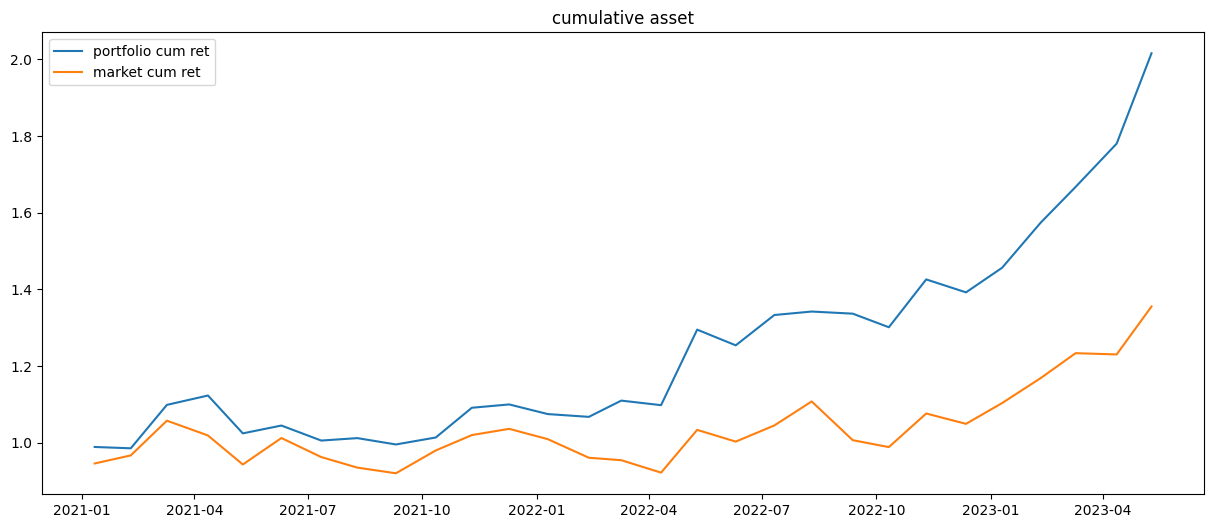

In [11]:
market_cum_asset = np.cumprod(1 + result["return"])
portfolio_cum_asset = np.cumprod(1 + result["performance"])
plt.figure(figsize=(15, 6))
plt.plot(portfolio_cum_asset, label="portfolio cum ret")
plt.plot(market_cum_asset, label = 'market cum ret')
plt.title("cumulative asset") 
plt.legend()
plt.show()